In [65]:

import matplotlib.pyplot as plt
import os

In [74]:
import numpy as np
def parse_file(quantum, run_count):
    benchmark_result = {}
    
    for rc in range(1,run_count+1):
        with open(f"rr_benchmark/quantum_{quantum}/run_{rc}.txt") as f:
            lines = list(f)
            benchmark_line = 0
            total_lines = len(lines)
            for i,l in enumerate(lines):
                if "=Benchmark=" in l:
                    benchmark_line = i
            ##############################
            for ci in range(benchmark_line + 1, total_lines, 2):
                command = lines[ci][:-1]
                result = lines[ci+1]
                if not command in benchmark_result.keys():
                    benchmark_result[command] = {"response_time": [], "burst_time": [], "turnaround_time": [], "waiting_time": []}
                
                components = list(map(lambda l: l.strip(), result.split(", ")))
                for comp in components:
                    comp_split = list(map(lambda c: c.strip(), comp.split(":")))
                    benchmark_result[command][comp_split[0]].append(int(comp_split[1]))

    return benchmark_result

def read_available_quantums(path):
    dir_names = list(map(lambda dir: dir.name ,list(os.scandir(path))))
    return sorted(list(map(lambda dir_name: int(dir_name.split("_")[1]) ,dir_names)))

def load_benchmark(ignore_outliers = True, transformer = None):
    results = {}
    for quantum in read_available_quantums("rr_benchmark"):
        benchmark_result = parse_file(quantum, 10)
        for command in benchmark_result.keys():
            if not command in results:
                results[command] = {"response_time": {}, "burst_time": {}, "turnaround_time": {}, "waiting_time": {}}
            
            for metric in ["response_time", "burst_time", "turnaround_time", "waiting_time"]:
                results[command][metric][quantum] = np.array(benchmark_result[command][metric])
                if ignore_outliers:
                    stats = results[command][metric][quantum]
                    stats_mean = stats.mean()
                    stats_std = stats.std()
                    filtered = stats[np.abs(stats - stats_mean) / stats_std <= 2]
                    if transformer is not None:
                        results[command][metric][quantum] = transformer(filtered)
    return results

In [81]:
results = load_benchmark(ignore_outliers=True, transformer=None)


In [82]:
command1 = list(results.keys())[0]
command2 = list(results.keys())[1]
command3 = list(results.keys())[2]

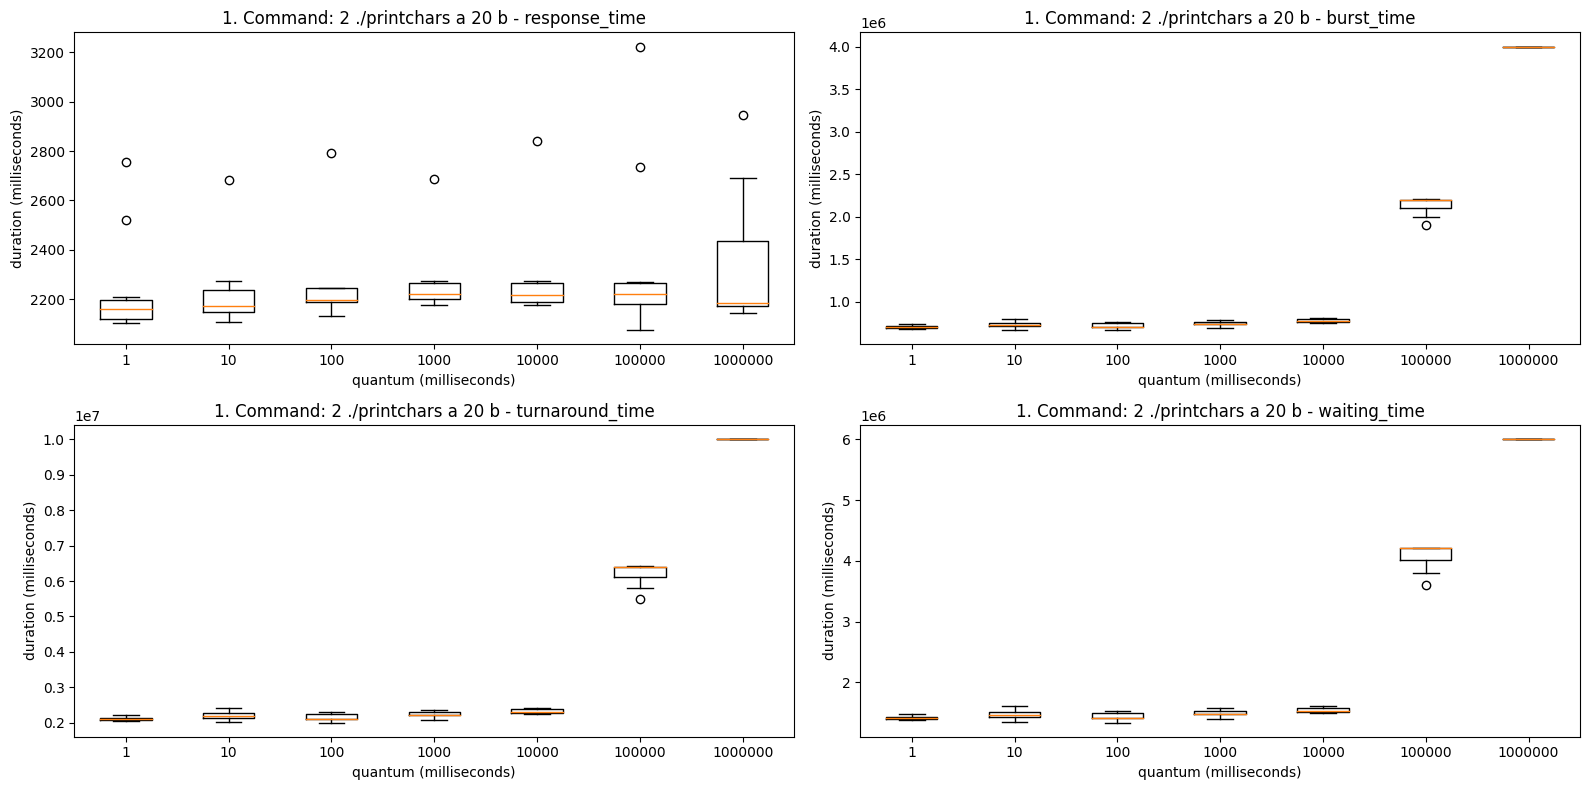

In [85]:
plt.figure(figsize=(16, 8), tight_layout=True) 

command = command1

for i,metric in enumerate(["response_time", "burst_time", "turnaround_time", "waiting_time"]):
    plt.subplot(2,2,i+1)
    target = results[command][metric]
    plt.title(f"1. {command} - {metric}")
    plt.xlabel("quantum (milliseconds)")
    plt.ylabel("duration (milliseconds)")
    plt.boxplot(target.values(), labels=target.keys(),whis=1.5);